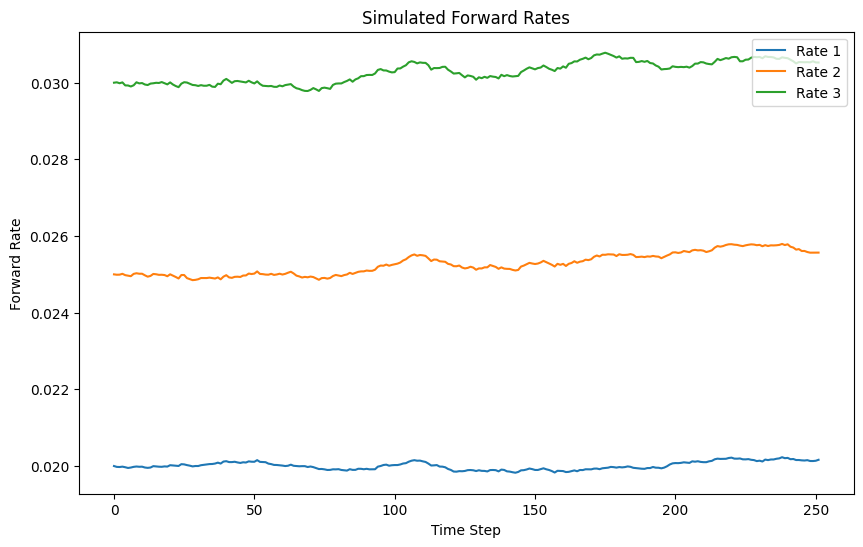

In [1]:
import numpy as np

class LiborMarketModel:
    def __init__(self, initial_rates, volatilities, correlations, dt):
        self.initial_rates = np.array(initial_rates)
        self.volatilities = np.array(volatilities)
        self.correlations = np.array(correlations)
        self.dt = dt
        self.num_rates = len(initial_rates)

    def simulate_paths(self, num_paths, T):
        num_steps = int(T / self.dt)
        rates = np.zeros((num_steps, num_paths, self.num_rates))
        rates[0, :, :] = self.initial_rates
        
        for t in range(1, num_steps):
            dt_sqrt = np.sqrt(self.dt)
            Z = np.random.normal(size=(num_paths, self.num_rates))
            correlated_Z = np.dot(Z, np.linalg.cholesky(self.correlations).T)
            
            for k in range(self.num_rates):
                drift = 0  # Placeholder for drift term, which could be added
                diffusion = self.volatilities[k] * correlated_Z[:, k] * dt_sqrt
                rates[t, :, k] = rates[t-1, :, k] + drift * self.dt + diffusion
                
        return rates

# Example initial setup
initial_rates = [0.02, 0.025, 0.03]
volatilities = [0.01, 0.015, 0.02]
correlations = np.array([[1.0, 0.8, 0.6],
                         [0.8, 1.0, 0.8],
                         [0.6, 0.8, 1.0]])
dt = 1/252  # Daily steps

# Initialize the LMM
lmm = LiborMarketModel(initial_rates, volatilities, correlations, dt)

# Simulate paths
num_paths = 1000
T = 1.0  # 1 year
simulated_rates = lmm.simulate_paths(num_paths, T)

# Plot the results (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(len(initial_rates)):
    plt.plot(np.mean(simulated_rates[:, :, i], axis=1), label=f'Rate {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Forward Rate')
plt.title('Simulated Forward Rates')
plt.legend()
plt.show()


In [2]:
import numpy as np

# Example market data (for simplicity, this example uses made-up data)
# Deposit rates (continuous compounding)
deposit_rates = [(0.25, 0.02), (0.5, 0.025)]  # (maturity in years, rate)

# Forward rate agreements (FRA) rates (continuous compounding)
fra_rates = [(0.75, 0.03), (1.0, 0.035)]  # (maturity in years, rate)

# Swap rates (annual payments, continuous compounding)
swap_rates = [(2, 0.04), (3, 0.045), (5, 0.05)]  # (maturity in years, rate)

def bootstrap_zero_curve(deposit_rates, fra_rates, swap_rates):
    # Bootstrapped zero rates
    zero_rates = []
    
    # Step 1: Bootstrap zero rates from deposit rates
    for maturity, rate in deposit_rates:
        zero_rates.append((maturity, rate))
    
    # Step 2: Bootstrap zero rates from FRA rates
    for maturity, rate in fra_rates:
        # Assume continuous compounding for simplicity
        previous_maturity, previous_rate = zero_rates[-1]
        df_previous = np.exp(-previous_rate * previous_maturity)
        df_current = df_previous / (1 + rate * (maturity - previous_maturity))
        zero_rate = -np.log(df_current) / maturity
        zero_rates.append((maturity, zero_rate))
    
    # Step 3: Bootstrap zero rates from swap rates
    for maturity, rate in swap_rates:
        # Assume annual payments for simplicity
        previous_maturity, previous_rate = zero_rates[-1]
        df_previous = np.exp(-previous_rate * previous_maturity)
        annuity = sum(np.exp(-r * t) for t, r in zero_rates)
        df_current = (1 - np.exp(-rate * maturity)) / rate
        zero_rate = -np.log(df_current / annuity) / maturity
        zero_rates.append((maturity, zero_rate))
    
    return zero_rates

zero_curve = bootstrap_zero_curve(deposit_rates, fra_rates, swap_rates)
print("Bootstrapped Zero Curve:")
for maturity, rate in zero_curve:
    print(f"Maturity: {maturity}, Zero Rate: {rate:.4f}")


Bootstrapped Zero Curve:
Maturity: 0.25, Zero Rate: 0.0200
Maturity: 0.5, Zero Rate: 0.0250
Maturity: 0.75, Zero Rate: 0.0266
Maturity: 1.0, Zero Rate: 0.0287
Maturity: 2, Zero Rate: 0.3582
Maturity: 3, Zero Rate: 0.1517
Maturity: 5, Zero Rate: 0.0268


Bootstrapped Zero Curve:
Maturity: 0.25, Zero Rate: 0.0200
Maturity: 0.5, Zero Rate: 0.0250
Maturity: 0.75, Zero Rate: 0.0266
Maturity: 1.0, Zero Rate: 0.0287
Maturity: 2, Zero Rate: 0.3582
Maturity: 3, Zero Rate: 0.1517
Maturity: 5, Zero Rate: 0.0268


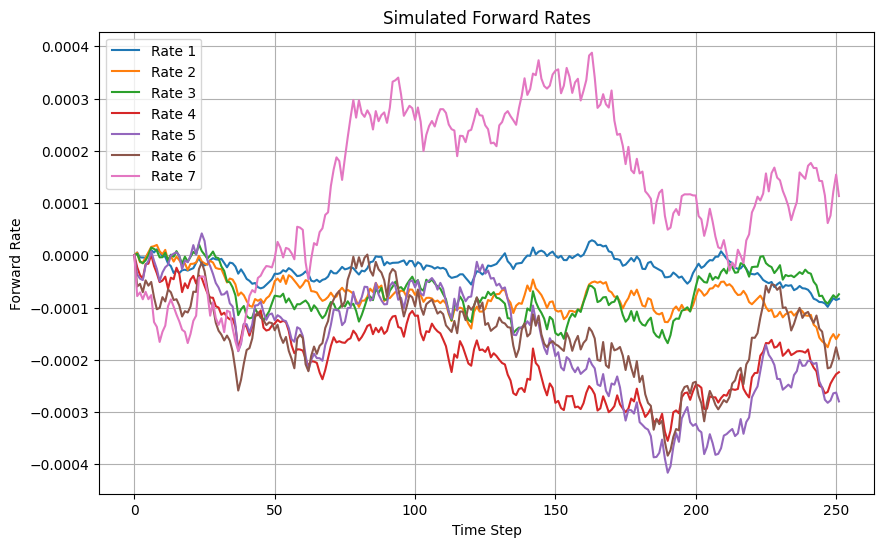

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Example market data (for simplicity, this example uses made-up data)
# Deposit rates (continuous compounding)
deposit_rates = [(0.25, 0.02), (0.5, 0.025)]  # (maturity in years, rate)

# Forward rate agreements (FRA) rates (continuous compounding)
fra_rates = [(0.75, 0.03), (1.0, 0.035)]  # (maturity in years, rate)

# Swap rates (annual payments, continuous compounding)
swap_rates = [(2, 0.04), (3, 0.045), (5, 0.05)]  # (maturity in years, rate)

def bootstrap_zero_curve(deposit_rates, fra_rates, swap_rates):
    # Bootstrapped zero rates
    zero_rates = []
    
    # Step 1: Bootstrap zero rates from deposit rates
    for maturity, rate in deposit_rates:
        zero_rates.append((maturity, rate))
    
    # Step 2: Bootstrap zero rates from FRA rates
    for maturity, rate in fra_rates:
        previous_maturity, previous_rate = zero_rates[-1]
        df_previous = np.exp(-previous_rate * previous_maturity)
        df_current = df_previous / (1 + rate * (maturity - previous_maturity))
        zero_rate = -np.log(df_current) / maturity
        zero_rates.append((maturity, zero_rate))
    
    # Step 3: Bootstrap zero rates from swap rates
    for maturity, rate in swap_rates:
        previous_maturity, previous_rate = zero_rates[-1]
        df_previous = np.exp(-previous_rate * previous_maturity)
        annuity = sum(np.exp(-r * t) for t, r in zero_rates if t <= maturity)
        df_current = (1 - np.exp(-rate * maturity)) / rate
        zero_rate = -np.log(df_current / annuity) / maturity
        zero_rates.append((maturity, zero_rate))
    
    return zero_rates

zero_curve = bootstrap_zero_curve(deposit_rates, fra_rates, swap_rates)
print("Bootstrapped Zero Curve:")
for maturity, rate in zero_curve:
    print(f"Maturity: {maturity}, Zero Rate: {rate:.4f}")

class InterestRateModel:
    def __init__(self, zero_curve, volatilities, correlations, dt):
        self.zero_curve = zero_curve
        self.volatilities = np.array(volatilities)
        self.correlations = np.array(correlations)
        self.dt = dt
        self.num_rates = len(zero_curve)

    def get_discount_factors(self):
        discount_factors = []
        for maturity, rate in self.zero_curve:
            df = np.exp(-rate * maturity)
            discount_factors.append(df)
        return np.array(discount_factors)
    
    def simulate_paths(self, num_paths, T):
        num_steps = int(T / self.dt)
        rates = np.zeros((num_steps, num_paths, self.num_rates))
        discount_factors = self.get_discount_factors()
        
        for t in range(1, num_steps):
            dt_sqrt = np.sqrt(self.dt)
            Z = np.random.normal(size=(num_paths, self.num_rates))
            L = np.linalg.cholesky(self.correlations)
            correlated_Z = Z @ L.T
            
            for k in range(self.num_rates):
                drift = 0  # Placeholder for drift term
                diffusion = self.volatilities[k] * correlated_Z[:, k] * dt_sqrt
                rates[t, :, k] = rates[t-1, :, k] + drift * self.dt + diffusion
                
        return rates

# Ensure the number of volatilities and correlations match the zero curve
volatilities = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
correlations = np.array([
    [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.1],
    [0.8, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
    [0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2],
    [0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4],
    [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6],
    [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8],
    [0.1, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
])
dt = 1/252  # Daily steps

# Initialize the interest rate model
irm = InterestRateModel(zero_curve, volatilities, correlations, dt)

# Simulate paths
num_paths = 10000
T = 1.0  # 1 year
simulated_rates = irm.simulate_paths(num_paths, T)

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(len(zero_curve)):
    plt.plot(np.mean(simulated_rates[:, :, i], axis=1), label=f'Rate {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Forward Rate')
plt.title('Simulated Forward Rates')
plt.legend()
plt.grid(True)
plt.show()


Bootstrapped Zero Curve:
Maturity: 0.25, Zero Rate: 0.0200
Maturity: 0.5, Zero Rate: 0.0250
Maturity: 0.75, Zero Rate: 0.0266
Maturity: 1.0, Zero Rate: 0.0287
Maturity: 2, Zero Rate: 0.3582
Maturity: 3, Zero Rate: 0.1517
Maturity: 5, Zero Rate: 0.0268


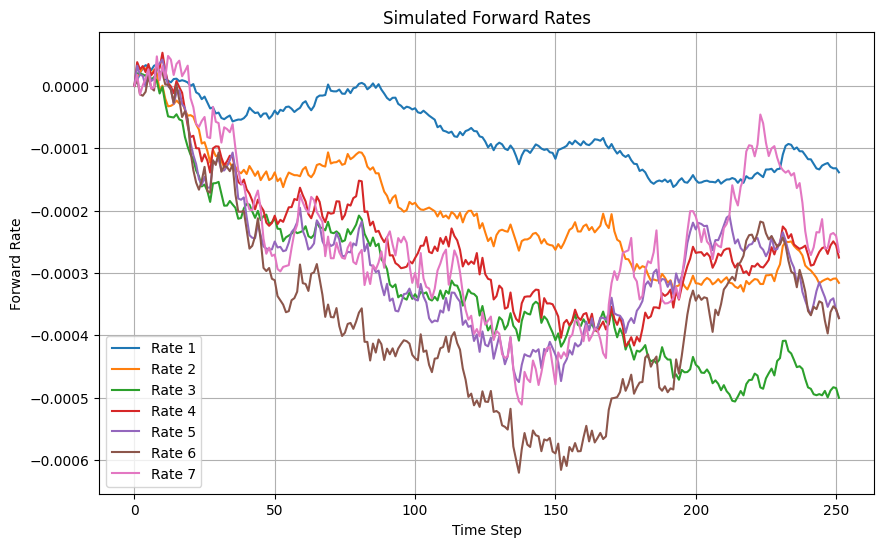

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Example market data (for simplicity, this example uses made-up data)
# Deposit rates (continuous compounding)
deposit_rates = [(0.25, 0.02), (0.5, 0.025)]  # (maturity in years, rate)

# Forward rate agreements (FRA) rates (continuous compounding)
fra_rates = [(0.75, 0.03), (1.0, 0.035)]  # (maturity in years, rate)

# Swap rates (annual payments, continuous compounding)
swap_rates = [(2, 0.04), (3, 0.045), (5, 0.05)]  # (maturity in years, rate)

def bootstrap_zero_curve(deposit_rates, fra_rates, swap_rates):
    zero_rates = []
    for maturity, rate in deposit_rates:
        zero_rates.append((maturity, rate))
    for maturity, rate in fra_rates:
        previous_maturity, previous_rate = zero_rates[-1]
        df_previous = np.exp(-previous_rate * previous_maturity)
        df_current = df_previous / (1 + rate * (maturity - previous_maturity))
        zero_rate = -np.log(df_current) / maturity
        zero_rates.append((maturity, zero_rate))
    for maturity, rate in swap_rates:
        previous_maturity, previous_rate = zero_rates[-1]
        df_previous = np.exp(-previous_rate * previous_maturity)
        annuity = sum(np.exp(-r * t) for t, r in zero_rates if t <= maturity)
        df_current = (1 - np.exp(-rate * maturity)) / rate
        zero_rate = -np.log(df_current / annuity) / maturity
        zero_rates.append((maturity, zero_rate))
    return zero_rates

zero_curve = bootstrap_zero_curve(deposit_rates, fra_rates, swap_rates)
print("Bootstrapped Zero Curve:")
for maturity, rate in zero_curve:
    print(f"Maturity: {maturity}, Zero Rate: {rate:.4f}")

class InterestRateModel:
    def __init__(self, zero_curve, vol_func, correlations, dt):
        self.zero_curve = zero_curve
        self.vol_func = vol_func
        self.correlations = np.array(correlations)
        self.dt = dt
        self.num_rates = len(zero_curve)

    def get_discount_factors(self):
        discount_factors = []
        for maturity, rate in self.zero_curve:
            df = np.exp(-rate * maturity)
            discount_factors.append(df)
        return np.array(discount_factors)
    
    def simulate_paths(self, num_paths, T):
        num_steps = int(T / self.dt)
        rates = np.zeros((num_steps, num_paths, self.num_rates))
        discount_factors = self.get_discount_factors()
        
        for t in range(1, num_steps):
            dt_sqrt = np.sqrt(self.dt)
            Z = np.random.normal(size=(num_paths, self.num_rates))
            L = np.linalg.cholesky(self.correlations)
            correlated_Z = Z @ L.T
            
            for k in range(self.num_rates):
                vol = self.vol_func(t * self.dt, k)
                drift = 0  # Placeholder for drift term
                diffusion = vol * correlated_Z[:, k] * dt_sqrt
                rates[t, :, k] = rates[t-1, :, k] + drift * self.dt + diffusion
                
        return rates

# Define a piecewise constant volatility function
def piecewise_constant_vol(t, k):
    # Example piecewise constant volatilities
    volatilities = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
    return volatilities[k]

# Example correlation matrix
correlations = np.array([
    [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.1],
    [0.8, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
    [0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2],
    [0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4],
    [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6],
    [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8],
    [0.1, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
])
dt = 1/252  # Daily steps

# Initialize the interest rate model with the piecewise constant volatility function
irm = InterestRateModel(zero_curve, piecewise_constant_vol, correlations, dt)

# Simulate paths
num_paths = 10000
T = 1.0  # 1 year
simulated_rates = irm.simulate_paths(num_paths, T)

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(len(zero_curve)):
    plt.plot(np.mean(simulated_rates[:, :, i], axis=1), label=f'Rate {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Forward Rate')
plt.title('Simulated Forward Rates')
plt.legend()
plt.grid(True)
plt.show()


Bootstrapped Zero Curve:
Maturity: 0.08 years, Zero Rate: 0.0100
Maturity: 0.25 years, Zero Rate: 0.0150
Maturity: 0.50 years, Zero Rate: 0.0200
Maturity: 1.00 years, Zero Rate: 0.0250
Maturity: 5.00 years, Zero Rate: 0.0300
Maturity: 10.00 years, Zero Rate: 0.0350
Maturity: 30.00 years, Zero Rate: 0.0400


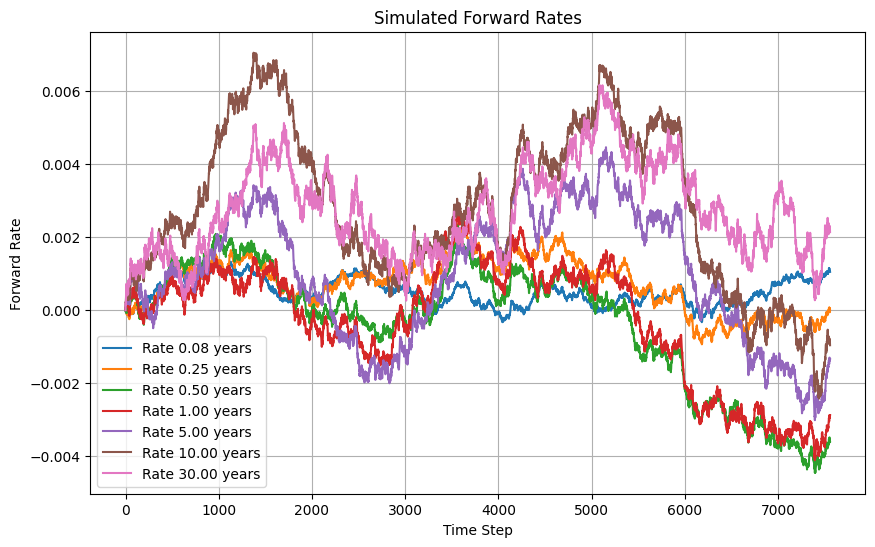

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define standard tenors in years
tenors = np.array([1/12, 3/12, 6/12, 1, 5, 10, 30])

# Example zero rates for the tenors (made-up data)
zero_rates = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]

# Create zero curve as a list of (maturity, rate) tuples
zero_curve = list(zip(tenors, zero_rates))

# Print the zero curve
print("Bootstrapped Zero Curve:")
for maturity, rate in zero_curve:
    print(f"Maturity: {maturity:.2f} years, Zero Rate: {rate:.4f}")

class InterestRateModel:
    def __init__(self, zero_curve, vol_func, correlations, dt):
        self.zero_curve = zero_curve
        self.vol_func = vol_func
        self.correlations = np.array(correlations)
        self.dt = dt
        self.num_rates = len(zero_curve)

    def get_discount_factors(self):
        discount_factors = []
        for maturity, rate in self.zero_curve:
            df = np.exp(-rate * maturity)
            discount_factors.append(df)
        return np.array(discount_factors)
    
    def simulate_paths(self, num_paths, T):
        num_steps = int(T / self.dt)
        rates = np.zeros((num_steps, num_paths, self.num_rates))
        discount_factors = self.get_discount_factors()
        
        for t in range(1, num_steps):
            dt_sqrt = np.sqrt(self.dt)
            Z = np.random.normal(size=(num_paths, self.num_rates))
            L = np.linalg.cholesky(self.correlations)
            correlated_Z = Z @ L.T
            
            for k in range(self.num_rates):
                vol = self.vol_func(t * self.dt, k)
                drift = 0  # Placeholder for drift term
                diffusion = vol * correlated_Z[:, k] * dt_sqrt
                rates[t, :, k] = rates[t-1, :, k] + drift * self.dt + diffusion
                
        return rates

# Define a piecewise constant volatility function
def piecewise_constant_vol(t, k):
    # Example piecewise constant volatilities
    volatilities = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
    return volatilities[k]

# Example correlation matrix for 7 tenors
correlations = np.array([
    [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.1],
    [0.8, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
    [0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2],
    [0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4],
    [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6],
    [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8],
    [0.1, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
])

# Time step for simulation (daily steps)
dt = 1/252

# Initialize the interest rate model with the piecewise constant volatility function
irm = InterestRateModel(zero_curve, piecewise_constant_vol, correlations, dt)

# Simulate paths
num_paths = 1000
T = 30  # 30 years
simulated_rates = irm.simulate_paths(num_paths, T)

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(len(zero_curve)):
    plt.plot(np.mean(simulated_rates[:, :, i], axis=1), label=f'Rate {tenors[i]:.2f} years')
plt.xlabel('Time Step')
plt.ylabel('Forward Rate')
plt.title('Simulated Forward Rates')
plt.legend()
plt.grid(True)
plt.show()


Bootstrapped Zero Curve:
Maturity: 0.08 years, Zero Rate: 0.0100
Maturity: 0.25 years, Zero Rate: 0.0150
Maturity: 0.50 years, Zero Rate: 0.0200
Maturity: 1.00 years, Zero Rate: 0.0250
Maturity: 5.00 years, Zero Rate: 0.0300
Maturity: 10.00 years, Zero Rate: 0.0350
Maturity: 30.00 years, Zero Rate: 0.0400


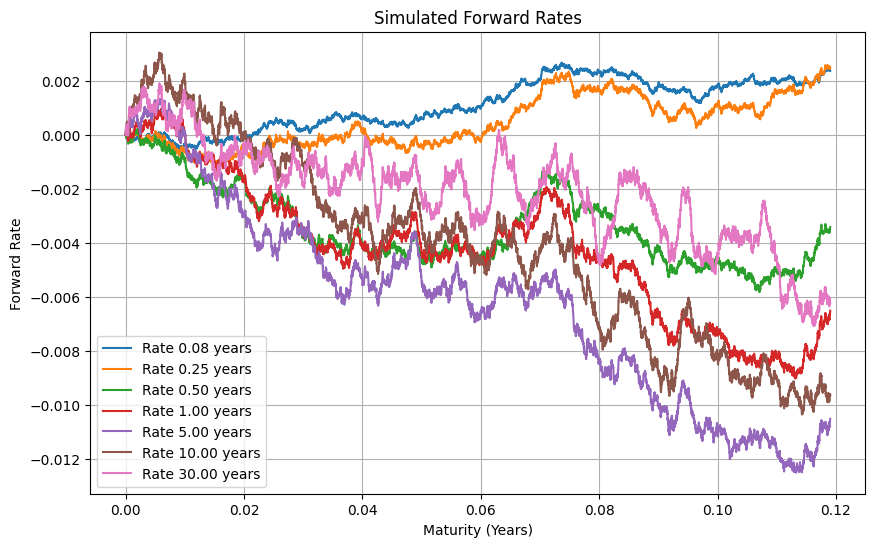

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define standard tenors in years
tenors = np.array([1/12, 3/12, 6/12, 1, 5, 10, 30])

# Example zero rates for the tenors (made-up data)
zero_rates = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]

# Create zero curve as a list of (maturity, rate) tuples
zero_curve = list(zip(tenors, zero_rates))

# Print the zero curve
print("Bootstrapped Zero Curve:")
for maturity, rate in zero_curve:
    print(f"Maturity: {maturity:.2f} years, Zero Rate: {rate:.4f}")

class InterestRateModel:
    def __init__(self, zero_curve, vol_func, correlations, dt):
        self.zero_curve = zero_curve
        self.vol_func = vol_func
        self.correlations = np.array(correlations)
        self.dt = dt
        self.num_rates = len(zero_curve)

    def get_discount_factors(self):
        discount_factors = []
        for maturity, rate in self.zero_curve:
            df = np.exp(-rate * maturity)
            discount_factors.append(df)
        return np.array(discount_factors)
    
    def simulate_paths(self, num_paths, T):
        num_steps = int(T / self.dt)
        rates = np.zeros((num_steps, num_paths, self.num_rates))
        discount_factors = self.get_discount_factors()
        
        for t in range(1, num_steps):
            dt_sqrt = np.sqrt(self.dt)
            Z = np.random.normal(size=(num_paths, self.num_rates))
            L = np.linalg.cholesky(self.correlations)
            correlated_Z = Z @ L.T
            
            for k in range(self.num_rates):
                vol = self.vol_func(t * self.dt, k)
                drift = 0  # Placeholder for drift term
                diffusion = vol * correlated_Z[:, k] * dt_sqrt
                rates[t, :, k] = rates[t-1, :, k] + drift * self.dt + diffusion
                
        return rates

# Define a piecewise constant volatility function
def piecewise_constant_vol(t, k):
    # Example piecewise constant volatilities
    volatilities = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
    return volatilities[k]

# Example correlation matrix for 7 tenors
correlations = np.array([
    [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.1],
    [0.8, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
    [0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2],
    [0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4],
    [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6],
    [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8],
    [0.1, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
])

# Time step for simulation (daily steps)
dt = 1/252

# Initialize the interest rate model with the piecewise constant volatility function
irm = InterestRateModel(zero_curve, piecewise_constant_vol, correlations, dt)

# Simulate paths
num_paths = 1000
T = 30  # 30 years
simulated_rates = irm.simulate_paths(num_paths, T)

# Create an array of time steps in years
time_steps = np.arange(0, T, dt)
time_steps_years = time_steps / 252  # Convert to years

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(len(zero_curve)):
    plt.plot(time_steps_years, np.mean(simulated_rates[:, :, i], axis=1), label=f'Rate {tenors[i]:.2f} years')
plt.xlabel('Maturity (Years)')
plt.ylabel('Forward Rate')
plt.title('Simulated Forward Rates')
plt.legend()
plt.grid(True)
plt.show()


Bootstrapped Zero Curve:
Maturity: 0.08 years, Zero Rate: 0.0100
Maturity: 0.25 years, Zero Rate: 0.0150
Maturity: 0.50 years, Zero Rate: 0.0200
Maturity: 1.00 years, Zero Rate: 0.0250
Maturity: 5.00 years, Zero Rate: 0.0300
Maturity: 10.00 years, Zero Rate: 0.0350
Maturity: 30.00 years, Zero Rate: 0.0400


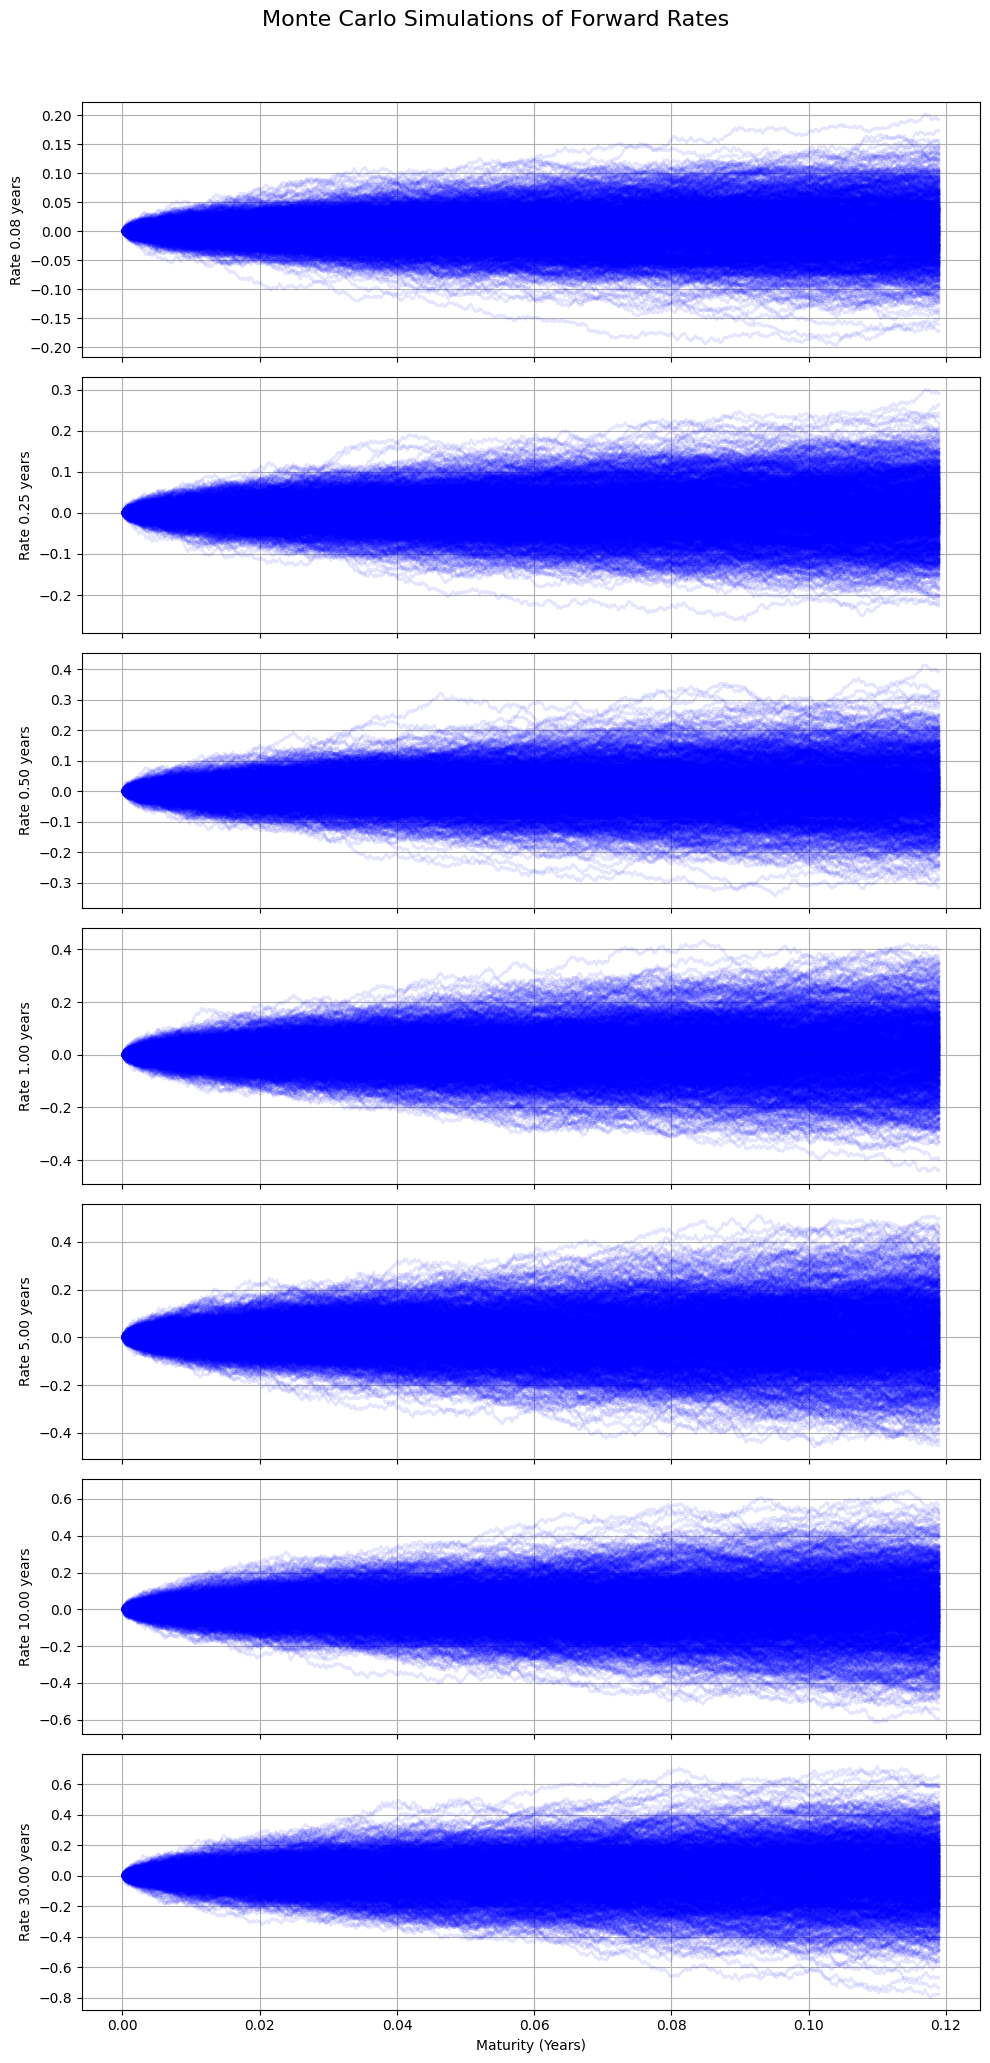

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define standard tenors in years
tenors = np.array([1/12, 3/12, 6/12, 1, 5, 10, 30])

# Example zero rates for the tenors (made-up data)
zero_rates = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]

# Create zero curve as a list of (maturity, rate) tuples
zero_curve = list(zip(tenors, zero_rates))

# Print the zero curve
print("Bootstrapped Zero Curve:")
for maturity, rate in zero_curve:
    print(f"Maturity: {maturity:.2f} years, Zero Rate: {rate:.4f}")

class InterestRateModel:
    def __init__(self, zero_curve, vol_func, correlations, dt):
        self.zero_curve = zero_curve
        self.vol_func = vol_func
        self.correlations = np.array(correlations)
        self.dt = dt
        self.num_rates = len(zero_curve)

    def get_discount_factors(self):
        discount_factors = []
        for maturity, rate in self.zero_curve:
            df = np.exp(-rate * maturity)
            discount_factors.append(df)
        return np.array(discount_factors)
    
    def simulate_paths(self, num_paths, T):
        num_steps = int(T / self.dt)
        rates = np.zeros((num_steps, num_paths, self.num_rates))
        discount_factors = self.get_discount_factors()
        
        for t in range(1, num_steps):
            dt_sqrt = np.sqrt(self.dt)
            Z = np.random.normal(size=(num_paths, self.num_rates))
            L = np.linalg.cholesky(self.correlations)
            correlated_Z = Z @ L.T
            
            for k in range(self.num_rates):
                vol = self.vol_func(t * self.dt, k)
                drift = 0  # Placeholder for drift term
                diffusion = vol * correlated_Z[:, k] * dt_sqrt
                rates[t, :, k] = rates[t-1, :, k] + drift * self.dt + diffusion
                
        return rates

# Define a piecewise constant volatility function
def piecewise_constant_vol(t, k):
    # Example piecewise constant volatilities
    volatilities = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
    return volatilities[k]

# Example correlation matrix for 7 tenors
correlations = np.array([
    [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.1],
    [0.8, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
    [0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2],
    [0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4],
    [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6],
    [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8],
    [0.1, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
])

# Time step for simulation (daily steps)
dt = 1/252

# Initialize the interest rate model with the piecewise constant volatility function
irm = InterestRateModel(zero_curve, piecewise_constant_vol, correlations, dt)

# Simulate paths
num_paths = 1000
T = 30  # 30 years
simulated_rates = irm.simulate_paths(num_paths, T)

# Create an array of time steps in years
time_steps = np.arange(0, T, dt)
time_steps_years = time_steps / 252  # Convert to years

# Plot the results
num_tenors = len(zero_curve)
fig, axes = plt.subplots(num_tenors, 1, figsize=(10, num_tenors*3), sharex=True)
fig.suptitle('Monte Carlo Simulations of Forward Rates', fontsize=16)

for i in range(num_tenors):
    ax = axes[i]
    for j in range(num_paths):
        ax.plot(time_steps_years, simulated_rates[:, j, i], alpha=0.1, color='blue')
    ax.set_ylabel(f'Rate {tenors[i]:.2f} years')
    ax.grid(True)

axes[-1].set_xlabel('Maturity (Years)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Bootstrapped Zero Curve:
Maturity: 0.08 years, Zero Rate: 0.0100
Maturity: 0.25 years, Zero Rate: 0.0150
Maturity: 0.50 years, Zero Rate: 0.0200
Maturity: 1.00 years, Zero Rate: 0.0250
Maturity: 5.00 years, Zero Rate: 0.0300
Maturity: 10.00 years, Zero Rate: 0.0350
Maturity: 30.00 years, Zero Rate: 0.0400


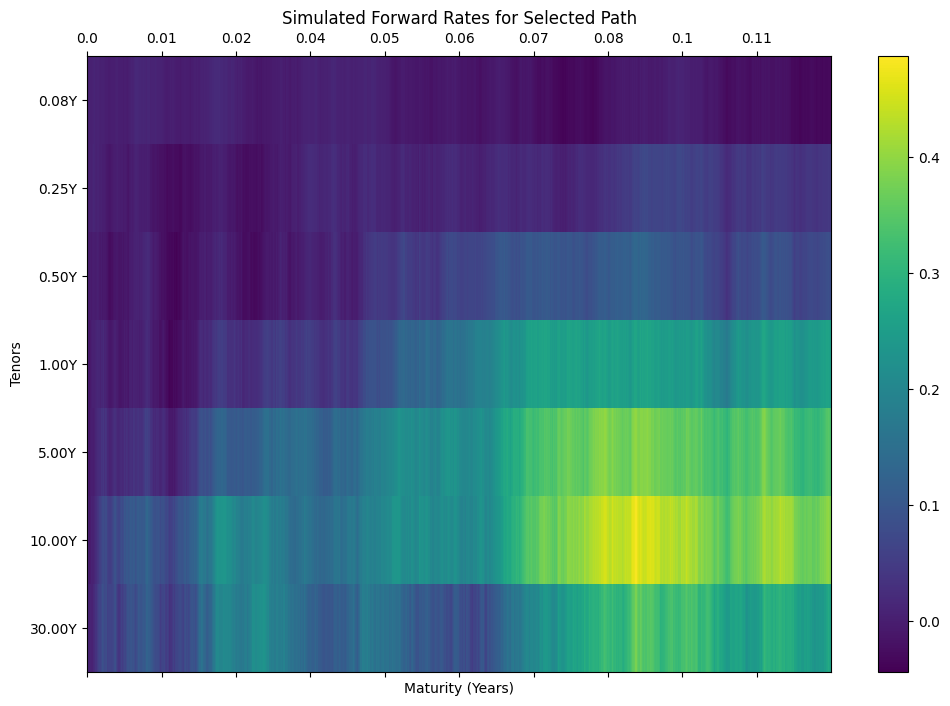

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define standard tenors in years
tenors = np.array([1/12, 3/12, 6/12, 1, 5, 10, 30])

# Example zero rates for the tenors (made-up data)
zero_rates = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]

# Create zero curve as a list of (maturity, rate) tuples
zero_curve = list(zip(tenors, zero_rates))

# Print the zero curve
print("Bootstrapped Zero Curve:")
for maturity, rate in zero_curve:
    print(f"Maturity: {maturity:.2f} years, Zero Rate: {rate:.4f}")

class InterestRateModel:
    def __init__(self, zero_curve, vol_func, correlations, dt):
        self.zero_curve = zero_curve
        self.vol_func = vol_func
        self.correlations = np.array(correlations)
        self.dt = dt
        self.num_rates = len(zero_curve)

    def get_discount_factors(self):
        discount_factors = []
        for maturity, rate in self.zero_curve:
            df = np.exp(-rate * maturity)
            discount_factors.append(df)
        return np.array(discount_factors)
    
    def simulate_paths(self, num_paths, T):
        num_steps = int(T / self.dt)
        rates = np.zeros((num_steps, num_paths, self.num_rates))
        discount_factors = self.get_discount_factors()
        
        for t in range(1, num_steps):
            dt_sqrt = np.sqrt(self.dt)
            Z = np.random.normal(size=(num_paths, self.num_rates))
            L = np.linalg.cholesky(self.correlations)
            correlated_Z = Z @ L.T
            
            for k in range(self.num_rates):
                vol = self.vol_func(t * self.dt, k)
                drift = 0  # Placeholder for drift term
                diffusion = vol * correlated_Z[:, k] * dt_sqrt
                rates[t, :, k] = rates[t-1, :, k] + drift * self.dt + diffusion
                
        return rates

# Define a piecewise constant volatility function
def piecewise_constant_vol(t, k):
    # Example piecewise constant volatilities
    volatilities = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
    return volatilities[k]

# Example correlation matrix for 7 tenors
correlations = np.array([
    [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.1],
    [0.8, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
    [0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2],
    [0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4],
    [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6],
    [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8],
    [0.1, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
])

# Time step for simulation (daily steps)
dt = 1/252

# Initialize the interest rate model with the piecewise constant volatility function
irm = InterestRateModel(zero_curve, piecewise_constant_vol, correlations, dt)

# Simulate paths
num_paths = 1000
T = 30  # 30 years
simulated_rates = irm.simulate_paths(num_paths, T)

# Create an array of time steps in years
time_steps = np.arange(0, T, dt)
time_steps_years = time_steps / 252  # Convert to years

# Select the paths for one of the iterations (example: the first path)
selected_path = simulated_rates[:, 0, :]  # Shape: (num_steps, num_rates)

# Plot the matrix of simulated rates
fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(selected_path.T, aspect='auto', cmap='viridis')
fig.colorbar(cax)

# Set x-axis labels to be time steps in years
ax.set_xticks(np.arange(0, len(time_steps_years), len(time_steps_years)//10))
ax.set_xticklabels(np.round(time_steps_years[::len(time_steps_years)//10], 2))

# Set y-axis labels to be the tenors
ax.set_yticks(np.arange(len(tenors)))
ax.set_yticklabels([f'{tenor:.2f}Y' for tenor in tenors])

ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Tenors')
plt.title('Simulated Forward Rates for Selected Path')
plt.show()


Bootstrapped Zero Curve:
Maturity: 0.08 years, Zero Rate: 0.0100
Maturity: 0.25 years, Zero Rate: 0.0150
Maturity: 0.50 years, Zero Rate: 0.0200
Maturity: 1.00 years, Zero Rate: 0.0250
Maturity: 5.00 years, Zero Rate: 0.0300
Maturity: 10.00 years, Zero Rate: 0.0350
Maturity: 30.00 years, Zero Rate: 0.0400
Average Forward Rates:
Tenor: 0.08 years, Rates: [ 0.00000000e+00 -2.22964432e-05 -2.49847663e-05 ...  3.49772605e-03
  3.49916232e-03  3.49463730e-03]
Tenor: 0.25 years, Rates: [ 0.00000000e+00 -3.90582285e-05 -5.69323722e-05 ...  3.57225700e-03
  3.57292536e-03  3.56134593e-03]
Tenor: 0.50 years, Rates: [ 0.00000000e+00 -8.86576427e-05 -9.35769698e-05 ...  4.95614562e-03
  4.96208614e-03  4.96589899e-03]
Tenor: 1.00 years, Rates: [ 0.00000000e+00 -9.63649958e-05 -1.42691649e-04 ...  9.46667648e-04
  9.58047542e-04  9.66864943e-04]
Tenor: 5.00 years, Rates: [ 0.00000000e+00 -8.06972696e-05 -9.18977006e-05 ...  4.28111106e-03
  4.27386095e-03  4.23359914e-03]
Tenor: 10.00 years, Rates

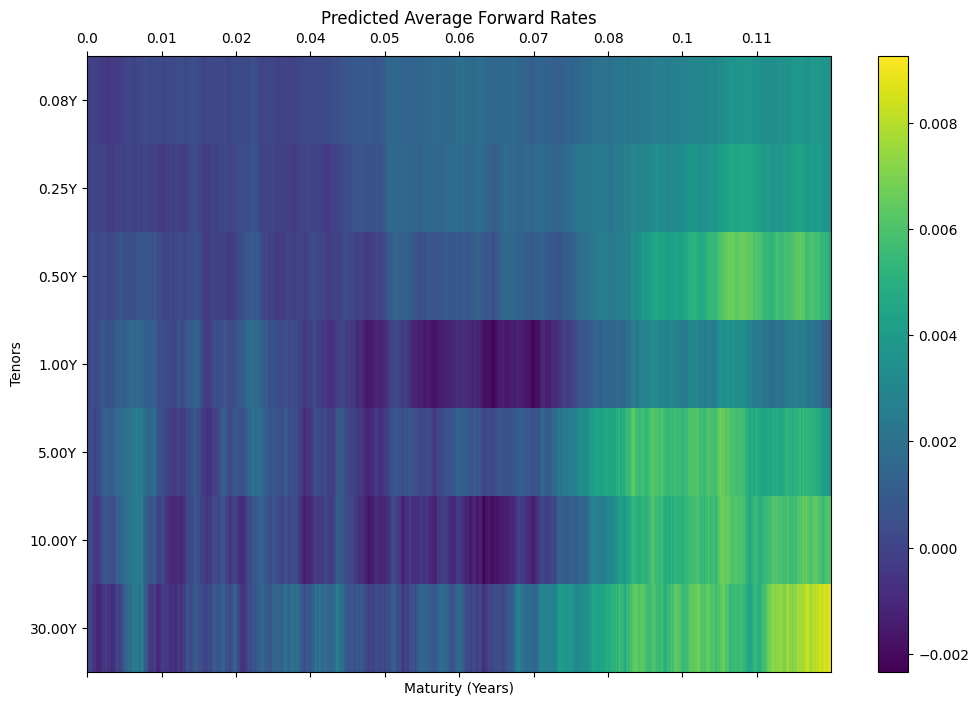

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define standard tenors in years
tenors = np.array([1/12, 3/12, 6/12, 1, 5, 10, 30])

# Example zero rates for the tenors (made-up data)
zero_rates = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]

# Create zero curve as a list of (maturity, rate) tuples
zero_curve = list(zip(tenors, zero_rates))

# Print the zero curve
print("Bootstrapped Zero Curve:")
for maturity, rate in zero_curve:
    print(f"Maturity: {maturity:.2f} years, Zero Rate: {rate:.4f}")

class InterestRateModel:
    def __init__(self, zero_curve, vol_func, correlations, dt):
        self.zero_curve = zero_curve
        self.vol_func = vol_func
        self.correlations = np.array(correlations)
        self.dt = dt
        self.num_rates = len(zero_curve)

    def get_discount_factors(self):
        discount_factors = []
        for maturity, rate in self.zero_curve:
            df = np.exp(-rate * maturity)
            discount_factors.append(df)
        return np.array(discount_factors)
    
    def simulate_paths(self, num_paths, T):
        num_steps = int(T / self.dt)
        rates = np.zeros((num_steps, num_paths, self.num_rates))
        discount_factors = self.get_discount_factors()
        
        for t in range(1, num_steps):
            dt_sqrt = np.sqrt(self.dt)
            Z = np.random.normal(size=(num_paths, self.num_rates))
            L = np.linalg.cholesky(self.correlations)
            correlated_Z = Z @ L.T
            
            for k in range(self.num_rates):
                vol = self.vol_func(t * self.dt, k)
                drift = 0  # Placeholder for drift term
                diffusion = vol * correlated_Z[:, k] * dt_sqrt
                rates[t, :, k] = rates[t-1, :, k] + drift * self.dt + diffusion
                
        return rates

# Define a piecewise constant volatility function
def piecewise_constant_vol(t, k):
    # Example piecewise constant volatilities
    volatilities = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
    return volatilities[k]

# Example correlation matrix for 7 tenors
correlations = np.array([
    [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.1],
    [0.8, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
    [0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2],
    [0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4],
    [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6],
    [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8],
    [0.1, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
])

# Time step for simulation (daily steps)
dt = 1/252

# Initialize the interest rate model with the piecewise constant volatility function
irm = InterestRateModel(zero_curve, piecewise_constant_vol, correlations, dt)

# Simulate paths
num_paths = 1000
T = 30  # 30 years
simulated_rates = irm.simulate_paths(num_paths, T)

# Calculate the average forward rates for each tenor at each time step
average_rates = np.mean(simulated_rates, axis=1)  # Shape: (num_steps, num_rates)

# Print the average forward rates
print("Average Forward Rates:")
for i, tenor in enumerate(tenors):
    print(f"Tenor: {tenor:.2f} years, Rates: {average_rates[:, i]}")

# Create an array of time steps in years
time_steps = np.arange(0, T, dt)
time_steps_years = time_steps / 252  # Convert to years

# Plot the matrix of predicted rates
fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(average_rates.T, aspect='auto', cmap='viridis')
fig.colorbar(cax)

# Set x-axis labels to be time steps in years
ax.set_xticks(np.arange(0, len(time_steps_years), len(time_steps_years)//10))
ax.set_xticklabels(np.round(time_steps_years[::len(time_steps_years)//10], 2))

# Set y-axis labels to be the tenors
ax.set_yticks(np.arange(len(tenors)))
ax.set_yticklabels([f'{tenor:.2f}Y' for tenor in tenors])

ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Tenors')
plt.title('Predicted Average Forward Rates')
plt.show()


In [17]:
# Print the average forward rates
print("Average Forward Rates:")
for i, tenor in enumerate(tenors):
    print(f"Tenor: {tenor:.2f} years, Rates: {average_rates[:, i]}")

Average Forward Rates:
Tenor: 0.08 years, Rates: [ 0.00000000e+00 -2.22964432e-05 -2.49847663e-05 ...  3.49772605e-03
  3.49916232e-03  3.49463730e-03]
Tenor: 0.25 years, Rates: [ 0.00000000e+00 -3.90582285e-05 -5.69323722e-05 ...  3.57225700e-03
  3.57292536e-03  3.56134593e-03]
Tenor: 0.50 years, Rates: [ 0.00000000e+00 -8.86576427e-05 -9.35769698e-05 ...  4.95614562e-03
  4.96208614e-03  4.96589899e-03]
Tenor: 1.00 years, Rates: [ 0.00000000e+00 -9.63649958e-05 -1.42691649e-04 ...  9.46667648e-04
  9.58047542e-04  9.66864943e-04]
Tenor: 5.00 years, Rates: [ 0.00000000e+00 -8.06972696e-05 -9.18977006e-05 ...  4.28111106e-03
  4.27386095e-03  4.23359914e-03]
Tenor: 10.00 years, Rates: [ 0.00000000e+00 -8.20208515e-05 -8.30045625e-05 ...  6.20917969e-03
  6.26125158e-03  6.25226019e-03]
Tenor: 30.00 years, Rates: [ 0.00000000e+00 -7.90285484e-05 -1.08969250e-05 ...  9.16069119e-03
  9.22892628e-03  9.27260918e-03]


In [18]:
tenors

array([ 0.08333333,  0.25      ,  0.5       ,  1.        ,  5.        ,
       10.        , 30.        ])

Bootstrapped Zero Curve:
Maturity: 0.08 years, Zero Rate: 0.0100
Maturity: 0.25 years, Zero Rate: 0.0150
Maturity: 0.50 years, Zero Rate: 0.0200
Maturity: 1.00 years, Zero Rate: 0.0250
Maturity: 5.00 years, Zero Rate: 0.0300
Maturity: 10.00 years, Zero Rate: 0.0350
Maturity: 30.00 years, Zero Rate: 0.0400
Average Forward Rates (Rows: Time Steps, Columns: Tenors):
Time Steps (Years): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
Tenors (Years): [ 0.08333333  0.25        0.5         1.          5.         10.
 30.        ]
[[ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.     -0.     -0.      0.0001  0.0001  0.0001  0.0001]
 [ 0.     -0.     -0.      0.      0.0001  0.      0.0001]
 [-0.     -0.     -0.0001 -0.     -0.     -0.0001 -0.    ]
 [ 0.     -0.     -0.0001 -0.0001 -0.0001 -0.     -0.    ]
 [-0.     -0.     -0.0001 -0.0001 -0.0001 -0.0001 -0.0001]
 [ 0.      0.     -0.0001 -0.0001 -0.0001 -0.0001 -0.0001]
 [ 0.      0.     -0.     -0.     -0.     -0.     -0.0001]
 [ 0.      

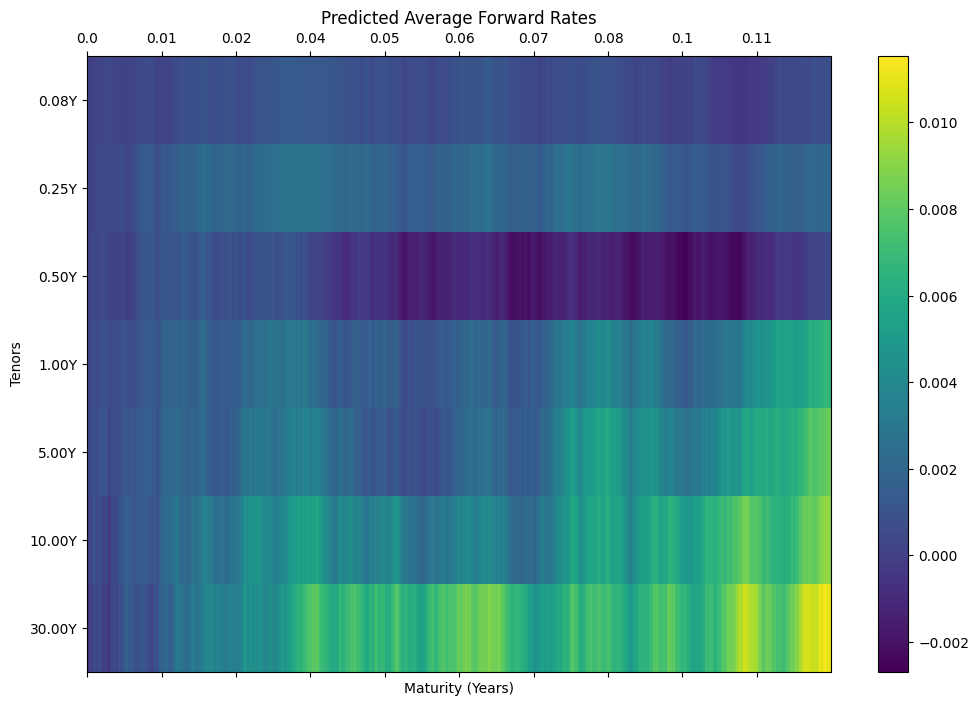

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define standard tenors in years
tenors = np.array([1/12, 3/12, 6/12, 1, 5, 10, 30])

# Example zero rates for the tenors (made-up data)
zero_rates = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]

# Create zero curve as a list of (maturity, rate) tuples
zero_curve = list(zip(tenors, zero_rates))

# Print the zero curve
print("Bootstrapped Zero Curve:")
for maturity, rate in zero_curve:
    print(f"Maturity: {maturity:.2f} years, Zero Rate: {rate:.4f}")

class InterestRateModel:
    def __init__(self, zero_curve, vol_func, correlations, dt):
        self.zero_curve = zero_curve
        self.vol_func = vol_func
        self.correlations = np.array(correlations)
        self.dt = dt
        self.num_rates = len(zero_curve)

    def get_discount_factors(self):
        discount_factors = []
        for maturity, rate in self.zero_curve:
            df = np.exp(-rate * maturity)
            discount_factors.append(df)
        return np.array(discount_factors)
    
    def simulate_paths(self, num_paths, T):
        num_steps = int(T / self.dt)
        rates = np.zeros((num_steps, num_paths, self.num_rates))
        discount_factors = self.get_discount_factors()
        
        for t in range(1, num_steps):
            dt_sqrt = np.sqrt(self.dt)
            Z = np.random.normal(size=(num_paths, self.num_rates))
            L = np.linalg.cholesky(self.correlations)
            correlated_Z = Z @ L.T
            
            for k in range(self.num_rates):
                vol = self.vol_func(t * self.dt, k)
                drift = 0  # Placeholder for drift term
                diffusion = vol * correlated_Z[:, k] * dt_sqrt
                rates[t, :, k] = rates[t-1, :, k] + drift * self.dt + diffusion
                
        return rates

# Define a piecewise constant volatility function
def piecewise_constant_vol(t, k):
    # Example piecewise constant volatilities
    volatilities = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
    return volatilities[k]

# Example correlation matrix for 7 tenors
correlations = np.array([
    [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.1],
    [0.8, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
    [0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2],
    [0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4],
    [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6],
    [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8],
    [0.1, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
])

# Time step for simulation (daily steps)
dt = 1/252

# Initialize the interest rate model with the piecewise constant volatility function
irm = InterestRateModel(zero_curve, piecewise_constant_vol, correlations, dt)

# Simulate paths
num_paths = 1000
T = 30  # 30 years
simulated_rates = irm.simulate_paths(num_paths, T)

# Calculate the average forward rates for each tenor at each time step
average_rates = np.mean(simulated_rates, axis=1)  # Shape: (num_steps, num_rates)

# Create an array of time steps in years
time_steps = np.arange(0, T, dt)
time_steps_years = time_steps / 252  # Convert to years

# Print the average forward rates as a matrix
print("Average Forward Rates (Rows: Time Steps, Columns: Tenors):")
print(f"Time Steps (Years): {np.round(time_steps_years[:10], 2)} ...")
print(f"Tenors (Years): {tenors}")
print(np.round(average_rates[:10, :], 4), "...")  # Print first 10 time steps for brevity

# Plot the matrix of predicted rates
fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(average_rates.T, aspect='auto', cmap='viridis')
fig.colorbar(cax)

# Set x-axis labels to be time steps in years
ax.set_xticks(np.arange(0, len(time_steps_years), len(time_steps_years)//10))
ax.set_xticklabels(np.round(time_steps_years[::len(time_steps_years)//10], 2))

# Set y-axis labels to be the tenors
ax.set_yticks(np.arange(len(tenors)))
ax.set_yticklabels([f'{tenor:.2f}Y' for tenor in tenors])

ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Tenors')
plt.title('Predicted Average Forward Rates')
plt.show()


In [40]:
# Print the average forward rates as a matrix
# rounded_tenors = round(tenors,2)
print("Average Forward Rates (Rows: Time Steps, Columns: Tenors):")
print(f"Time Steps (Years): {np.round(time_steps_years[:10], 4)} ...")
print(f"Tenors (Years):")
print(f"{np.round(tenors,6)}")
print(np.round(average_rates[:20, :], 6), "...")  # Print first 20 time steps for brevity

Average Forward Rates (Rows: Time Steps, Columns: Tenors):
Time Steps (Years): [0.     0.     0.     0.     0.0001 0.0001 0.0001 0.0001 0.0001 0.0001] ...
Tenors (Years):
[ 0.083333  0.25      0.5       1.        5.       10.       30.      ]
[[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 1.60e-05 -3.00e-06 -8.00e-06  7.90e-05  7.90e-05  9.50e-05  9.30e-05]
 [ 3.00e-06 -1.80e-05 -3.00e-05  2.30e-05  7.50e-05  1.80e-05  9.70e-05]
 [-2.30e-05 -3.90e-05 -9.20e-05 -3.20e-05 -2.30e-05 -7.70e-05 -3.30e-05]
 [ 5.00e-06 -1.60e-05 -6.50e-05 -8.30e-05 -6.40e-05 -5.00e-05 -3.10e-05]
 [-9.00e-06 -3.30e-05 -1.11e-04 -1.36e-04 -1.23e-04 -1.19e-04 -1.07e-04]
 [ 3.20e-05  2.40e-05 -6.00e-05 -9.70e-05 -9.80e-05 -1.02e-04 -1.03e-04]
 [ 1.90e-05  1.90e-05 -1.10e-05 -4.30e-05 -2.20e-05 -1.90e-05 -1.07e-04]
 [ 3.10e-05  5.80e-05 -4.00e-06 -3.80e-05  1.80e-05 -2.20e-05 -2.12e-04]
 [ 2.90e-05  8.90e-05  3.90e-05  2.00e-06  6.30e-05 -6.10e-05 -3.00e-04]
 [ 6.30e-05  1.15e-04  3.90

Bootstrapped Zero Curve:
Maturity: 0.08 years, Zero Rate: 0.0100
Maturity: 0.25 years, Zero Rate: 0.0150
Maturity: 0.50 years, Zero Rate: 0.0200
Maturity: 1.00 years, Zero Rate: 0.0250
Maturity: 5.00 years, Zero Rate: 0.0300
Maturity: 10.00 years, Zero Rate: 0.0350
Maturity: 30.00 years, Zero Rate: 0.0400
Average Forward Rates (Rows: Time Steps, Columns: Tenors):
Time Steps (Years): [0.     0.     0.     0.     0.0001 0.0001 0.0001 0.0001 0.0001 0.0001] ...
Tenors (Years):
[ 0.083333  0.25      0.5       1.        5.       10.       30.      ]
[[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [-3.00e-05 -2.10e-05  3.00e-06  1.00e-06 -3.80e-05 -1.70e-05 -5.90e-05]
 [-4.50e-05 -4.60e-05 -1.60e-05 -4.70e-05 -1.31e-04 -1.00e-06 -1.70e-05]
 [-3.70e-05 -3.50e-05  7.00e-06  1.20e-05 -1.35e-04 -4.10e-05 -1.88e-04]
 [-5.20e-05 -3.90e-05 -2.00e-05  3.50e-05 -1.21e-04 -2.40e-05 -1.94e-04]
 [-4.40e-05 -3.00e-05 -1.80e-05 -1.30e-05 -2.05e-04 -5.70e-05 -1.52e-04]
 [-5.70e-05 

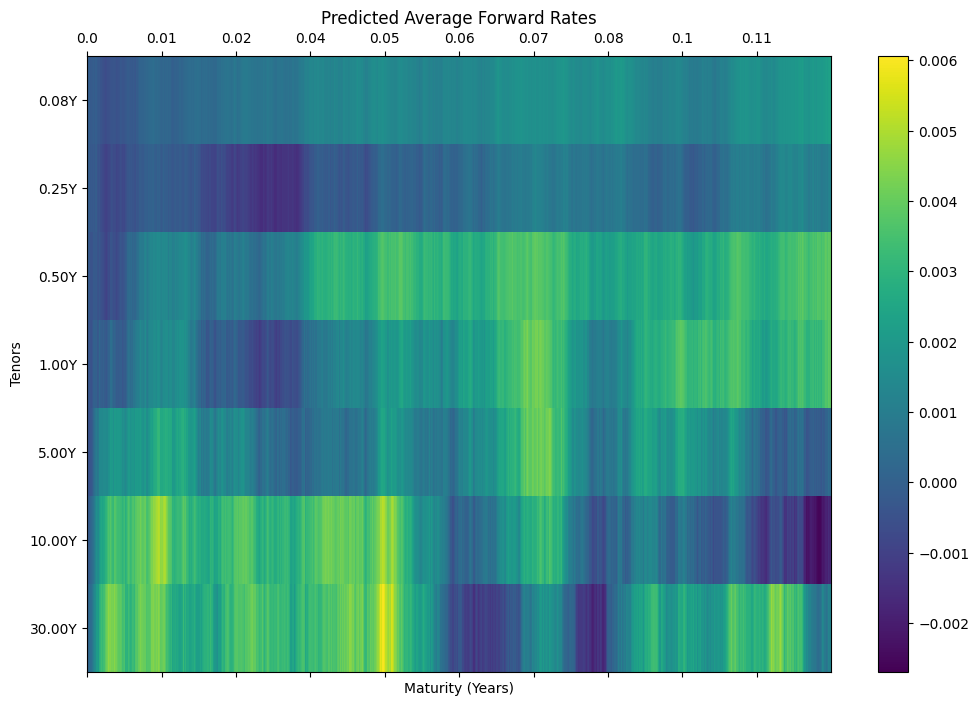

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define standard tenors in years
tenors = np.array([1/12, 3/12, 6/12, 1, 5, 10, 30])

# Example zero rates for the tenors (made-up data)
zero_rates = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]

# Create zero curve as a list of (maturity, rate) tuples
zero_curve = list(zip(tenors, zero_rates))

# Print the zero curve
print("Bootstrapped Zero Curve:")
for maturity, rate in zero_curve:
    print(f"Maturity: {maturity:.2f} years, Zero Rate: {rate:.4f}")

class InterestRateModel:
    def __init__(self, zero_curve, vol_func, correlations, dt):
        self.zero_curve = zero_curve
        self.vol_func = vol_func
        self.correlations = np.array(correlations)
        self.dt = dt
        self.num_rates = len(zero_curve)

    def get_discount_factors(self):
        discount_factors = []
        for maturity, rate in self.zero_curve:
            df = np.exp(-rate * maturity)
            discount_factors.append(df)
        return np.array(discount_factors)
    
    def simulate_paths(self, num_paths, T):
        num_steps = int(T / self.dt)
        rates = np.zeros((num_steps, num_paths, self.num_rates))
        discount_factors = self.get_discount_factors()
        
        for t in range(1, num_steps):
            dt_sqrt = np.sqrt(self.dt)
            Z = np.random.normal(size=(num_paths, self.num_rates))
            L = np.linalg.cholesky(self.correlations)
            correlated_Z = Z @ L.T
            
            for k in range(self.num_rates):
                vol = self.vol_func(t * self.dt, k)
                drift = 0  # Placeholder for drift term
                diffusion = vol * correlated_Z[:, k] * dt_sqrt
                rates[t, :, k] = rates[t-1, :, k] + drift * self.dt + diffusion
                
        return rates

# Define a piecewise constant volatility function
def piecewise_constant_vol(t, k):
    # Example piecewise constant volatilities
    volatilities = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
    return volatilities[k]

# Example correlation matrix for 7 tenors
correlations = np.array([
    [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.1],
    [0.8, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
    [0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2],
    [0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4],
    [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6],
    [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8],
    [0.1, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
])

# Time step for simulation (daily steps)
dt = 1/252

# Initialize the interest rate model with the piecewise constant volatility function
irm = InterestRateModel(zero_curve, piecewise_constant_vol, correlations, dt)

# Simulate paths
num_paths = 1000
T = 30  # 30 years
simulated_rates = irm.simulate_paths(num_paths, T)

# Calculate the average forward rates for each tenor at each time step
average_rates = np.mean(simulated_rates, axis=1)  # Shape: (num_steps, num_rates)

# Create an array of time steps in years
time_steps = np.arange(0, T, dt)
time_steps_years = time_steps / 252  # Convert to years

# Print the average forward rates as a matrix
print("Average Forward Rates (Rows: Time Steps, Columns: Tenors):")
print(f"Time Steps (Years): {np.round(time_steps_years[:10], 4)} ...")
print(f"Tenors (Years):")
print(f"{np.round(tenors,6)}")
print(np.round(average_rates[:20, :], 6), "...")  # Print first 20 time steps for brevity

# Convert the average forward rates to a DataFrame for better display
df = pd.DataFrame(np.round(average_rates[:20, :], 6), columns=[f"{tenor:.2f}Y" for tenor in tenors])
df.index = np.round(time_steps_years[:20], 8)

# Display the DataFrame as a table
print(df)

# Plot the matrix of predicted rates
fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(average_rates.T, aspect='auto', cmap='viridis')
fig.colorbar(cax)

# Set x-axis labels to be time steps in years
ax.set_xticks(np.arange(0, len(time_steps_years), len(time_steps_years)//10))
ax.set_xticklabels(np.round(time_steps_years[::len(time_steps_years)//10], 2))

# Set y-axis labels to be the tenors
ax.set_yticks(np.arange(len(tenors)))
ax.set_yticklabels([f'{tenor:.2f}Y' for tenor in tenors])

ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Tenors')
plt.title('Predicted Average Forward Rates')
plt.show()


In [44]:
df

,0.08Y,0.25Y,0.50Y,1.00Y,5.00Y,10.00Y,30.00Y
0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.000016,-0.000030,-0.000021,0.000003,0.000001,-0.000038,-0.000017,-0.000059
0.000031,-0.000045,-0.000046,-0.000016,-0.000047,-0.000131,-0.000001,-0.000017
0.000047,-0.000037,-0.000035,0.000007,0.000012,-0.000135,-0.000041,-0.000188
0.000063,-0.000052,-0.000039,-0.000020,0.000035,-0.000121,-0.000024,-0.000194
0.000079,-0.000044,-0.000030,-0.000018,-0.000013,-0.000205,-0.000057,-0.000152
0.000094,-0.000057,-0.000067,-0.000085,-0.000061,-0.000286,-0.000139,-0.000204
0.000110,-0.000056,-0.000068,-0.000128,-0.000126,-0.000345,-0.000204,-0.000216
0.000126,-0.000034,-0.000038,-0.000138,-0.000119,-0.000304,-0.000112,-0.000035
0.000142,-0.000040,-0.000022,-0.000163,-0.000187,-0.000336,-0.000202,-0.000047


Bootstrapped Zero Curve:
Maturity: 0.08 years, Zero Rate: 0.0100
Maturity: 0.25 years, Zero Rate: 0.0150
Maturity: 0.50 years, Zero Rate: 0.0200
Maturity: 1.00 years, Zero Rate: 0.0250
Maturity: 5.00 years, Zero Rate: 0.0300
Maturity: 10.00 years, Zero Rate: 0.0350
Maturity: 30.00 years, Zero Rate: 0.0400
Predicted Forward Rates for Each Tenor (1000 Predictions):
        0.08Y     0.25Y     0.50Y     1.00Y     5.00Y    10.00Y    30.00Y
0    0.158392  0.117891  0.146870  0.067497  0.090103  0.100925  0.013099
1    0.030618  0.014815  0.046694 -0.015749 -0.032735  0.117243  0.025540
2   -0.002360 -0.010199 -0.069771 -0.037428 -0.031731 -0.031619 -0.213112
3   -0.070257 -0.061532 -0.132406 -0.011081 -0.200559 -0.280350 -0.198877
4    0.014387  0.071282  0.120154  0.087681 -0.112272 -0.272702 -0.334058
..        ...       ...       ...       ...       ...       ...       ...
995  0.056034  0.182949  0.065350  0.063494 -0.208889 -0.272339 -0.274552
996 -0.022466 -0.044624 -0.162091 -0.17839

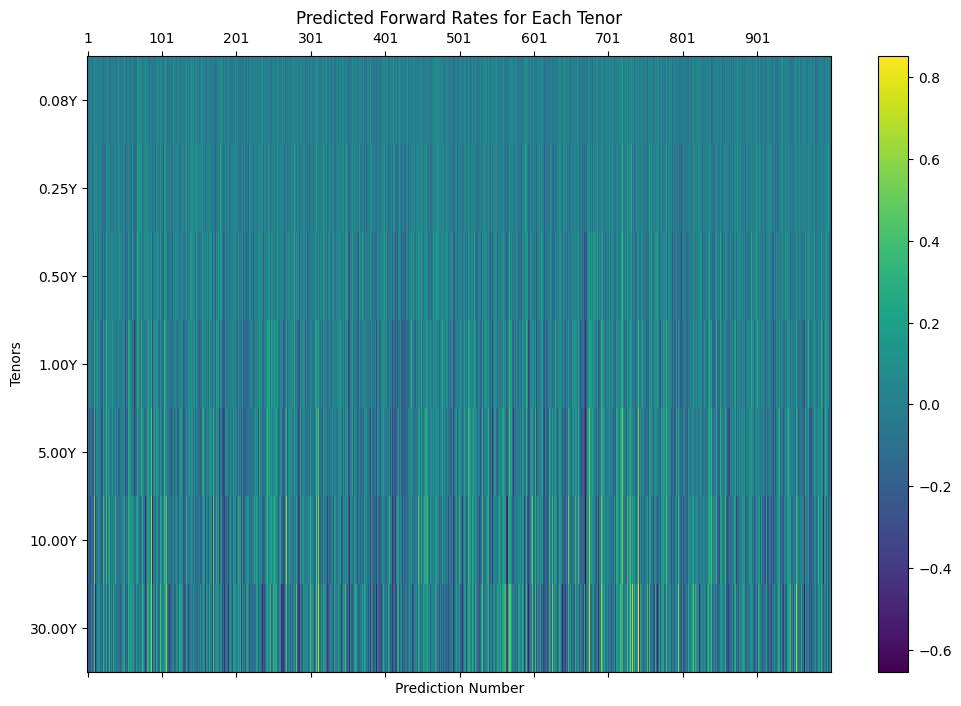

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define standard tenors in years
tenors = np.array([1/12, 3/12, 6/12, 1, 5, 10, 30])

# Example zero rates for the tenors (made-up data)
zero_rates = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]

# Create zero curve as a list of (maturity, rate) tuples
zero_curve = list(zip(tenors, zero_rates))

# Print the zero curve
print("Bootstrapped Zero Curve:")
for maturity, rate in zero_curve:
    print(f"Maturity: {maturity:.2f} years, Zero Rate: {rate:.4f}")

class InterestRateModel:
    def __init__(self, zero_curve, vol_func, correlations, dt):
        self.zero_curve = zero_curve
        self.vol_func = vol_func
        self.correlations = np.array(correlations)
        self.dt = dt
        self.num_rates = len(zero_curve)

    def get_discount_factors(self):
        discount_factors = []
        for maturity, rate in self.zero_curve:
            df = np.exp(-rate * maturity)
            discount_factors.append(df)
        return np.array(discount_factors)
    
    def simulate_paths(self, num_paths, T):
        num_steps = int(T / self.dt)
        rates = np.zeros((num_steps, num_paths, self.num_rates))
        discount_factors = self.get_discount_factors()
        
        for t in range(1, num_steps):
            dt_sqrt = np.sqrt(self.dt)
            Z = np.random.normal(size=(num_paths, self.num_rates))
            L = np.linalg.cholesky(self.correlations)
            correlated_Z = Z @ L.T
            
            for k in range(self.num_rates):
                vol = self.vol_func(t * self.dt, k)
                drift = 0  # Placeholder for drift term
                diffusion = vol * correlated_Z[:, k] * dt_sqrt
                rates[t, :, k] = rates[t-1, :, k] + drift * self.dt + diffusion
                
        return rates

# Define a piecewise constant volatility function
def piecewise_constant_vol(t, k):
    # Example piecewise constant volatilities
    volatilities = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
    return volatilities[k]

# Example correlation matrix for 7 tenors
correlations = np.array([
    [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.1],
    [0.8, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
    [0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2],
    [0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4],
    [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6],
    [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8],
    [0.1, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
])

# Time step for simulation (daily steps)
dt = 1/252

# Initialize the interest rate model with the piecewise constant volatility function
irm = InterestRateModel(zero_curve, piecewise_constant_vol, correlations, dt)

# Simulate paths
num_paths = 1000
T = 30  # 30 years
simulated_rates = irm.simulate_paths(num_paths, T)

# Extract the forward rates for each tenor at the end of the simulation period
final_rates = simulated_rates[-1, :, :]  # Shape: (num_paths, num_rates)

# Convert the final rates to a DataFrame
df = pd.DataFrame(np.round(final_rates, 6), columns=[f"{tenor:.2f}Y" for tenor in tenors])

# Display the DataFrame as a table
print("Predicted Forward Rates for Each Tenor (1000 Predictions):")
print(df)

# Plot the matrix of predicted rates
fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(final_rates.T, aspect='auto', cmap='viridis')
fig.colorbar(cax)

# Set x-axis labels to be predictions (rows)
ax.set_xticks(np.arange(0, num_paths, num_paths//10))
ax.set_xticklabels(np.arange(1, num_paths + 1, num_paths//10))

# Set y-axis labels to be the tenors
ax.set_yticks(np.arange(len(tenors)))
ax.set_yticklabels([f'{tenor:.2f}Y' for tenor in tenors])

ax.set_xlabel('Prediction Number')
ax.set_ylabel('Tenors')
plt.title('Predicted Forward Rates for Each Tenor')
plt.show()


In [46]:
df

,0.08Y,0.25Y,0.50Y,1.00Y,5.00Y,10.00Y,30.00Y
0,0.158392,0.117891,0.146870,0.067497,0.090103,0.100925,0.013099
1,0.030618,0.014815,0.046694,-0.015749,-0.032735,0.117243,0.025540
2,-0.002360,-0.010199,-0.069771,-0.037428,-0.031731,-0.031619,-0.213112
3,-0.070257,-0.061532,-0.132406,-0.011081,-0.200559,-0.280350,-0.198877
4,0.014387,0.071282,0.120154,0.087681,-0.112272,-0.272702,-0.334058
...,...,...,...,...,...,...,...
995,0.056034,0.182949,0.065350,0.063494,-0.208889,-0.272339,-0.274552
996,-0.022466,-0.044624,-0.162091,-0.178398,-0.181019,-0.085453,-0.117309
997,-0.055626,-0.145705,-0.117633,-0.034564,-0.018903,0.162688,0.218725
998,-0.037539,0.000673,0.017758,0.139037,0.024895,-0.100483,-0.188046


Bootstrapped Zero Curve:
Maturity: 0.08 years, Zero Rate: 0.0100
Maturity: 0.25 years, Zero Rate: 0.0150
Maturity: 0.50 years, Zero Rate: 0.0200
Maturity: 1.00 years, Zero Rate: 0.0250
Maturity: 5.00 years, Zero Rate: 0.0450
Maturity: 10.00 years, Zero Rate: 0.0650
Maturity: 30.00 years, Zero Rate: 0.0850
Predicted Forward Rates for Each Tenor (1000 Predictions):
        0.08Y     0.25Y     0.50Y     1.00Y     5.00Y    10.00Y    30.00Y
0    0.003755 -0.013447 -0.064898 -0.037158 -0.066796 -0.122460 -0.121437
1   -0.004312  0.070331  0.076958  0.080923  0.056895 -0.047195 -0.202399
2   -0.052078 -0.085320 -0.093182 -0.088315 -0.008487  0.293125  0.441240
3   -0.035815 -0.021333 -0.031932 -0.061042  0.094867  0.081736  0.128589
4   -0.074886 -0.063978 -0.091746 -0.126090 -0.096936 -0.239123 -0.126146
..        ...       ...       ...       ...       ...       ...       ...
995 -0.062983 -0.074313 -0.149225 -0.151487 -0.095722 -0.040695 -0.056320
996  0.022651 -0.001443 -0.083339 -0.15898

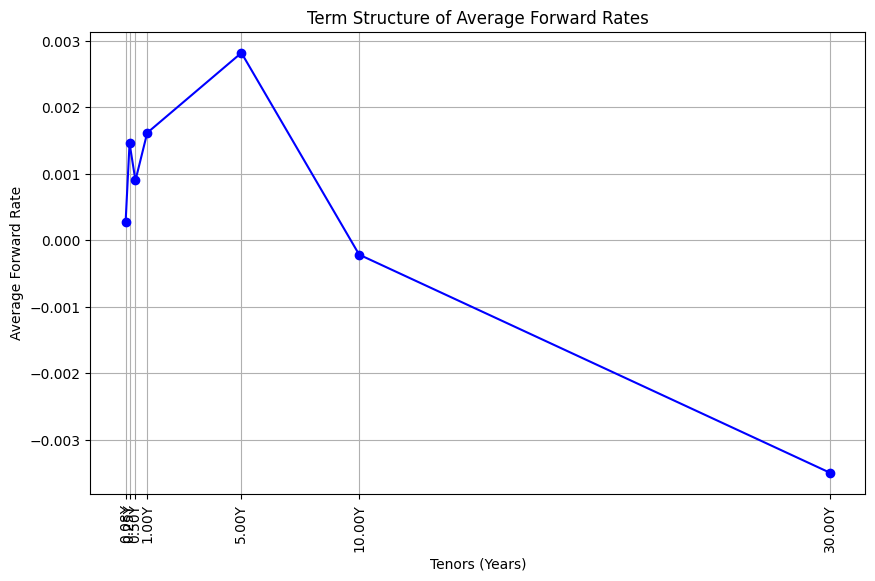

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define standard tenors in years
tenors = np.array([1/12, 3/12, 6/12, 1, 5, 10, 30])

# Example zero rates for the tenors (made-up data)
zero_rates = [0.01, 0.015, 0.02, 0.025, 0.045, 0.065, 0.085]

# Create zero curve as a list of (maturity, rate) tuples
zero_curve = list(zip(tenors, zero_rates))

# Print the zero curve
print("Bootstrapped Zero Curve:")
for maturity, rate in zero_curve:
    print(f"Maturity: {maturity:.2f} years, Zero Rate: {rate:.4f}")

class InterestRateModel:
    def __init__(self, zero_curve, vol_func, correlations, dt):
        self.zero_curve = zero_curve
        self.vol_func = vol_func
        self.correlations = np.array(correlations)
        self.dt = dt
        self.num_rates = len(zero_curve)

    def get_discount_factors(self):
        discount_factors = []
        for maturity, rate in self.zero_curve:
            df = np.exp(-rate * maturity)
            discount_factors.append(df)
        return np.array(discount_factors)
    
    def simulate_paths(self, num_paths, T):
        num_steps = int(T / self.dt)
        rates = np.zeros((num_steps, num_paths, self.num_rates))
        discount_factors = self.get_discount_factors()
        
        for t in range(1, num_steps):
            dt_sqrt = np.sqrt(self.dt)
            Z = np.random.normal(size=(num_paths, self.num_rates))
            L = np.linalg.cholesky(self.correlations)
            correlated_Z = Z @ L.T
            
            for k in range(self.num_rates):
                vol = self.vol_func(t * self.dt, k)
                drift = 0  # Placeholder for drift term
                diffusion = vol * correlated_Z[:, k] * dt_sqrt
                rates[t, :, k] = rates[t-1, :, k] + drift * self.dt + diffusion
                
        return rates

# Define a piecewise constant volatility function
def piecewise_constant_vol(t, k):
    # Example piecewise constant volatilities
    volatilities = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
    return volatilities[k]

# Example correlation matrix for 7 tenors
correlations = np.array([
    [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.1],
    [0.8, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
    [0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2],
    [0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4],
    [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6],
    [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8],
    [0.1, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
])

# Time step for simulation (daily steps)
dt = 1/252

# Initialize the interest rate model with the piecewise constant volatility function
irm = InterestRateModel(zero_curve, piecewise_constant_vol, correlations, dt)

# Simulate paths
num_paths = 1000
T = 30  # 30 years
simulated_rates = irm.simulate_paths(num_paths, T)

# Extract the final forward rates for each tenor at the end of the simulation period
final_rates = simulated_rates[-1, :, :]  # Shape: (num_paths, num_rates)

# Calculate the average forward rates for each tenor
average_final_rates = np.mean(final_rates, axis=0)
# max_final_rates = np.max(final_rates, axis=0)

# Convert the final rates to a DataFrame
df = pd.DataFrame(np.round(final_rates, 6), columns=[f"{tenor:.2f}Y" for tenor in tenors])

# Display the DataFrame as a table
print("Predicted Forward Rates for Each Tenor (1000 Predictions):")
print(df)

# Plot the term structure as the average of the predicted values
plt.figure(figsize=(10, 6))
plt.plot(tenors, average_final_rates, marker='o', linestyle='-', color='b')
plt.xlabel('Tenors (Years)')
plt.ylabel('Average Forward Rate')
plt.title('Term Structure of Average Forward Rates')
plt.grid(True)
plt.xticks(tenors, [f"{tenor:.2f}Y" for tenor in tenors], rotation=90)
plt.show()


Bootstrapped Zero Curve:
Maturity: 0.08 years, Zero Rate: 0.0100
Maturity: 0.25 years, Zero Rate: 0.0150
Maturity: 0.50 years, Zero Rate: 0.0200
Maturity: 1.00 years, Zero Rate: 0.0250
Maturity: 5.00 years, Zero Rate: 0.0300
Maturity: 10.00 years, Zero Rate: 0.0350
Maturity: 30.00 years, Zero Rate: 0.0400
Predicted Forward Rates for Each Tenor (1000 Predictions):
        0.08Y     0.25Y     0.50Y     1.00Y     5.00Y    10.00Y    30.00Y
0   -0.042603  0.038669  0.003992 -0.104452 -0.062531 -0.102875 -0.267992
1    0.045922  0.021449  0.069362 -0.019791 -0.070019 -0.122182  0.012174
2   -0.012059  0.022613  0.078690  0.074197  0.122468 -0.057862 -0.218545
3    0.078542  0.060530  0.020190  0.092535  0.171461  0.306441  0.409109
4   -0.022077 -0.007503  0.013958  0.056798  0.065498 -0.122395 -0.085491
..        ...       ...       ...       ...       ...       ...       ...
995  0.009691 -0.008468  0.080107  0.142026  0.098639  0.033198  0.091698
996 -0.045311 -0.058445 -0.033193 -0.04565

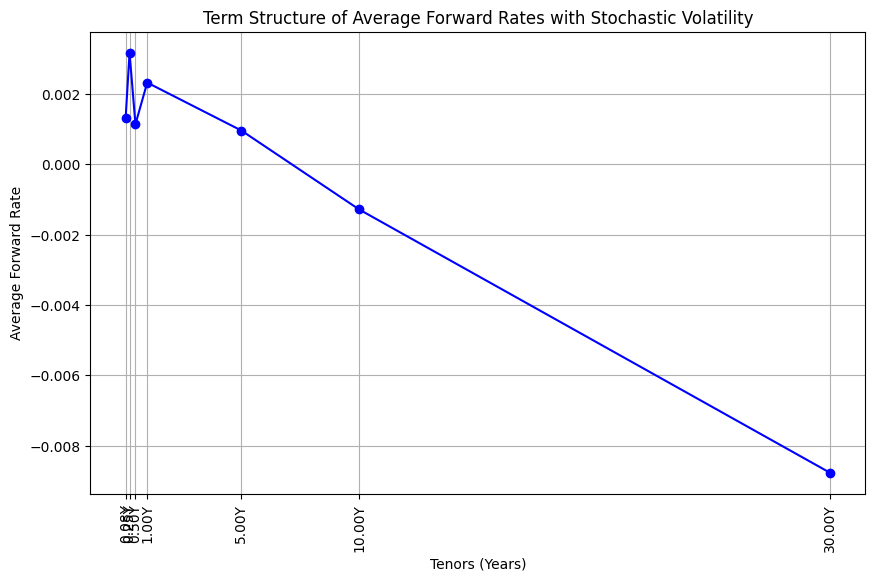

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define standard tenors in years
tenors = np.array([1/12, 3/12, 6/12, 1, 5, 10, 30])

# Example zero rates for the tenors (made-up data)
zero_rates = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]

# Create zero curve as a list of (maturity, rate) tuples
zero_curve = list(zip(tenors, zero_rates))

# Print the zero curve
print("Bootstrapped Zero Curve:")
for maturity, rate in zero_curve:
    print(f"Maturity: {maturity:.2f} years, Zero Rate: {rate:.4f}")

class InterestRateModel:
    def __init__(self, zero_curve, vol_params, correlations, dt):
        self.zero_curve = zero_curve
        self.vol_params = vol_params  # Initial volatility, mean reversion level, vol of volatility
        self.correlations = np.array(correlations)
        self.dt = dt
        self.num_rates = len(zero_curve)

    def get_discount_factors(self):
        discount_factors = []
        for maturity, rate in self.zero_curve:
            df = np.exp(-rate * maturity)
            discount_factors.append(df)
        return np.array(discount_factors)
    
    def simulate_paths(self, num_paths, T):
        num_steps = int(T / self.dt)
        rates = np.zeros((num_steps, num_paths, self.num_rates))
        volatilities = np.zeros((num_steps, num_paths, self.num_rates))
        
        initial_vol, mean_reversion, vol_of_vol = self.vol_params
        volatilities[0, :, :] = initial_vol
        
        discount_factors = self.get_discount_factors()
        
        for t in range(1, num_steps):
            dt_sqrt = np.sqrt(self.dt)
            Z_rates = np.random.normal(size=(num_paths, self.num_rates))
            Z_vols = np.random.normal(size=(num_paths, self.num_rates))
            L = np.linalg.cholesky(self.correlations)
            correlated_Z_rates = Z_rates @ L.T
            correlated_Z_vols = Z_vols @ L.T
            
            for k in range(self.num_rates):
                # Update volatilities using GBM
                volatilities[t, :, k] = volatilities[t-1, :, k] * np.exp(
                    -0.5 * vol_of_vol[k]**2 * self.dt +
                    vol_of_vol[k] * dt_sqrt * correlated_Z_vols[:, k]
                )
                
                vol = volatilities[t, :, k]
                drift = 0  # Placeholder for drift term
                diffusion = vol * correlated_Z_rates[:, k] * dt_sqrt
                rates[t, :, k] = rates[t-1, :, k] + drift * self.dt + diffusion
                
        return rates, volatilities

# Define initial volatility, mean reversion level, and volatility of volatility for each tenor
vol_params = [
    (0.01, 0.015, 0.02),
    (0.015, 0.02, 0.025),
    (0.02, 0.025, 0.03),
    (0.025, 0.03, 0.035),
    (0.03, 0.035, 0.04),
    (0.035, 0.04, 0.045),
    (0.04, 0.045, 0.05)
]

# Split vol_params into initial vol, mean reversion, and vol of vol arrays
initial_vol = [param[0] for param in vol_params]
mean_reversion = [param[1] for param in vol_params]
vol_of_vol = [param[2] for param in vol_params]

# Example correlation matrix for 7 tenors
correlations = np.array([
    [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.1],
    [0.8, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
    [0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2],
    [0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4],
    [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6],
    [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8],
    [0.1, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
])

# Time step for simulation (daily steps)
dt = 1/252

# Initialize the interest rate model with stochastic volatility
irm = InterestRateModel(zero_curve, (initial_vol, mean_reversion, vol_of_vol), correlations, dt)

# Simulate paths
num_paths = 1000
T = 30  # 30 years
simulated_rates, simulated_vols = irm.simulate_paths(num_paths, T)

# Extract the final forward rates for each tenor at the end of the simulation period
final_rates = simulated_rates[-1, :, :]  # Shape: (num_paths, num_rates)

# Calculate the average forward rates for each tenor
average_final_rates = np.mean(final_rates, axis=0)

# Convert the final rates to a DataFrame
df = pd.DataFrame(np.round(final_rates, 6), columns=[f"{tenor:.2f}Y" for tenor in tenors])

# Display the DataFrame as a table
print("Predicted Forward Rates for Each Tenor (1000 Predictions):")
print(df)

# Plot the term structure as the average of the predicted values
plt.figure(figsize=(10, 6))
plt.plot(tenors, average_final_rates, marker='o', linestyle='-', color='b')
plt.xlabel('Tenors (Years)')
plt.ylabel('Average Forward Rate')
plt.title('Term Structure of Average Forward Rates with Stochastic Volatility')
plt.grid(True)
plt.xticks(tenors, [f"{tenor:.2f}Y" for tenor in tenors], rotation=90)  # Rotate labels to be vertical
# plt.xlim(0, tenors[-1] + 1)  # Adding a bit more space to the x-axis limit for better visualization
plt.show()
